# 用户画像

用户行为和属性分析

# 步骤
## 1.导入相应包，并读取数据、预处理数据
实验数据为名为“taobao_persona.csv”的csv文件\
代码如下：

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
#警告过滤器用于控制警告消息的行为，如忽略，显示或转换为错误（引发异常）

In [4]:
#导入数据集
df_orginal = pd.read_csv('taobao_persona.csv')
#抽取部分数据数据
df = df_orginal.sample(frac=0.2,random_state=None)
#回收内存
del df_orginal
gc.collect()

0

In [5]:
#看下数据大小
df.shape

(4658205, 6)

In [6]:
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
13042656,34290307,134288404,1,NaN,6054,2014-12-01 17
14747875,56120016,33204956,1,9rdmnot,292,2014-12-12 22
4160368,20961417,5945371,1,NaN,3000,2014-11-27 15
6352755,46476827,353584282,1,NaN,5376,2014-11-20 23
9891583,121526027,284398094,1,NaN,3940,2014-11-27 13


In [70]:
df['date'].max()

Timestamp('2014-12-18 00:00:00')

In [71]:
df['date'].min()

Timestamp('2014-11-18 00:00:00')

这是30天的数据集

In [8]:
#查看其中是否有缺失值，统计各字段缺失值
df.isnull().any()

user_id          False
item_id          False
behavior_type    False
user_geohash      True
item_category    False
time             False
dtype: bool

In [7]:
df.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     3182124
item_category          0
time                   0
dtype: int64

In [9]:
# 发现只有user_geohash有缺失值，且缺失的比例很高，无统计分析的意义，将此列删除。
#删除缺失列
df.drop('user_geohash',axis=1,inplace=True)

In [10]:
#将time字段拆分为日期和时段
df['date'] = df['time'].str[0:10]
df['time'] = df['time'].str[11:]
df['time'] = df['time'].astype(int)

In [11]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date
13042656,34290307,134288404,1,6054,17,2014-12-01
14747875,56120016,33204956,1,292,22,2014-12-12
4160368,20961417,5945371,1,3000,15,2014-11-27
6352755,46476827,353584282,1,5376,23,2014-11-20
9891583,121526027,284398094,1,3940,13,2014-11-27


In [13]:
#将时段分为'凌晨'、'上午'、'中午'、'下午'、'晚上'
df['hour'] = pd.cut(df['time'],bins=[-1,5,10,13,18,24],labels=['凌晨','上午','中午','下午','晚上'])
df.sample(5)

,user_id,item_id,behavior_type,item_category,time,date,hour
1365004,115969784,336623839,1,4254,21,2014-12-05,晚上
6700361,50329876,35655881,1,1863,22,2014-11-25,晚上
16800305,117316478,257856549,1,11,21,2014-11-30,晚上
13004257,33905986,152966146,1,10894,10,2014-11-22,上午
2752783,132156050,386309906,1,5204,23,2014-12-04,晚上


In [14]:
#生成用户标签表，制作好的标签都加入这个表中
users = df['user_id'].unique()
users

array([ 34290307,  56120016,  20961417, ..., 111771619,  14062926,
       137572563], dtype=int64)

In [15]:
labels = pd.DataFrame(users,columns=['user_id'])

In [16]:
labels.head(5)

,user_id
0,34290307
1,56120016
2,20961417
3,46476827
4,121526027


## 2.构建用户行为标签
### 2.1 用户浏览活跃时间段

In [23]:
#对用户和时段分组，统计浏览次数
time_browse = df[df['behavior_type']==1].groupby(['user_id','hour']).item_id.count().reset_index()
time_browse.rename(columns={'item_id':'hour_counts'},inplace=True)
time_browse[:10]

,user_id,hour,hour_counts
0,492,凌晨,0
1,492,上午,7
2,492,中午,6
3,492,下午,11
4,492,晚上,30
5,3726,凌晨,2
6,3726,上午,0
7,3726,中午,6
8,3726,下午,23
9,3726,晚上,45


In [24]:
#统计每个用户浏览次数最多的时段
time_browse_max = time_browse.groupby('user_id').hour_counts.max().reset_index()
time_browse_max.rename(columns={'hour_counts':'read_counts_max'},inplace=True)
time_browse = pd.merge(time_browse,time_browse_max,how='left',on='user_id')
time_browse

,user_id,hour,hour_counts,read_counts_max
0,492,凌晨,0,30
1,492,上午,7,30
2,492,中午,6,30
3,492,下午,11,30
4,492,晚上,30,30
...,...,...,...,...
99760,142442955,凌晨,0,50
99761,142442955,上午,6,50
99762,142442955,中午,9,50
99763,142442955,下午,15,50


In [25]:
#选取各用户浏览次数最多的时段，如有并列最多的时段，用逗号连接
time_browse_hour=time_browse.loc[time_browse['hour_counts']==time_browse['read_counts_max'],'hour'].groupby(time_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index() #逗号连接多个时间段
time_browse_hour.head()

,user_id,hour
0,492,晚上
1,3726,晚上
2,19137,晚上
3,36465,中午
4,37101,下午


In [26]:
#将用户浏览活跃时间段加入到用户标签表中
labels = pd.merge(labels,time_browse_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_browse'},inplace=True)
labels.head(5)

,user_id,time_browse
0,34290307,晚上
1,56120016,晚上
2,20961417,下午
3,46476827,晚上
4,121526027,凌晨


### 2.2 生成购买活跃时间段

In [27]:
time_buy = df[df['behavior_type']==4].groupby(['user_id','hour']).item_id.count().reset_index()
time_buy.rename(columns={'item_id':'hour_counts'},inplace=True)
time_buy_max = time_buy.groupby('user_id').hour_counts.max().reset_index()
time_buy_max.rename(columns={'hour_counts':'buy_counts_max'},inplace=True)
time_buy = pd.merge(time_buy,time_buy_max,how='left',on='user_id')
time_buy_hour=time_buy.loc[time_buy['hour_counts']==time_buy['buy_counts_max'],'hour'].groupby(time_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()
time_buy_hour.head()

,user_id,hour
0,492,中午
1,3726,晚上
2,37101,中午
3,38745,中午
4,45561,"凌晨,上午"


In [28]:
labels = pd.merge(labels,time_buy_hour,how='left',on='user_id')
labels.rename(columns={'hour':'time_buy'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy
0,34290307,晚上,"上午,中午"
1,56120016,晚上,下午
2,20961417,下午,下午
3,46476827,晚上,下午
4,121526027,凌晨,下午


In [29]:
del time_browse
del time_buy
del time_browse_hour
del time_browse_max
del time_buy_hour
del time_buy_max
gc.collect()

40

之前确定推荐的有效时间段，后续确定推荐的有效商品

### 2.3 用户行为

In [30]:
df_browse = df.loc[df['behavior_type']==1,['user_id','item_id','item_category']]
df_collect = df.loc[df['behavior_type']==2,['user_id','item_id','item_category']]
df_cart = df.loc[df['behavior_type']==3,['user_id','item_id','item_category']]
df_buy = df.loc[df['behavior_type']==4,['user_id','item_id','item_category']]

#### 2.3.1 浏览最多的类目

In [31]:
#对用户与类目进行分组，统计浏览次数
df_cate_most_browse = df_browse.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_browse.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_browse.head()

,user_id,item_category,item_category_counts
0,492,280,1
1,492,675,1
2,492,2170,7
3,492,2298,1
4,492,2413,1


In [32]:
#统计每个用户浏览次数最多的类目
df_cate_most_browse_max=df_cate_most_browse.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_browse_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_browse_max.head()

,user_id,item_category_counts_max
0,492,8
1,3726,6
2,19137,3
3,36465,4
4,37101,68


In [33]:
df_cate_most_browse = pd.merge(df_cate_most_browse,df_cate_most_browse_max,how='left',on='user_id')
df_cate_most_browse['item_category'] = df_cate_most_browse['item_category'].astype(str)
df_cate_most_browse.head()

,user_id,item_category,item_category_counts,item_category_counts_max
0,492,280,1,8
1,492,675,1,8
2,492,2170,7,8
3,492,2298,1,8
4,492,2413,1,8


In [34]:
#选取各用户浏览次数最多的类目，如有并列最多的类目，用逗号连接
df_cate_browse=df_cate_most_browse.loc[df_cate_most_browse['item_category_counts']==df_cate_most_browse['item_category_counts_max'],'item_category'].groupby(df_cate_most_browse['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_browse.head()


,user_id,item_category
0,492,6344
1,3726,9516
2,19137,11856
3,36465,3064
4,37101,1863


In [35]:
#将用户浏览最多的类目加入到用户标签表中
labels = pd.merge(labels,df_cate_browse,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_browse'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse
0,34290307,晚上,"上午,中午",5399
1,56120016,晚上,下午,3628
2,20961417,下午,下午,6054
3,46476827,晚上,下午,6513
4,121526027,凌晨,下午,5399


#### 2.3.2 收藏最多的类目


In [36]:
#生成逻辑与浏览最多的类目相同
df_cate_most_collect = df_collect.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_collect.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_collect_max=df_cate_most_collect.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_collect_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_collect = pd.merge(df_cate_most_collect,df_cate_most_collect_max,how='left',on='user_id')
df_cate_most_collect['item_category'] = df_cate_most_collect['item_category'].astype(str)
df_cate_collect=df_cate_most_collect.loc[df_cate_most_collect['item_category_counts']==df_cate_most_collect['item_category_counts_max'],'item_category'].groupby(df_cate_most_collect['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_collect.head()


,user_id,item_category
0,38745,6513
1,45561,3783
2,59436,6610
3,60723,11304
4,100605,11379


In [37]:
labels = pd.merge(labels,df_cate_collect,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_collect'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect
0,34290307,晚上,"上午,中午",5399,6936
1,56120016,晚上,下午,3628,1337
2,20961417,下午,下午,6054,NaN
3,46476827,晚上,下午,6513,5399
4,121526027,凌晨,下午,5399,"3940,5027,6513"


#### 2.3.3 加购最多的类目

In [38]:
#生成逻辑与浏览最多的类目相同
df_cate_most_cart = df_cart.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_cart = df_cart.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_cart.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_cart_max = df_cate_most_cart.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_cart_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_cart = pd.merge(df_cate_most_cart,df_cate_most_cart_max,how='left',on='user_id')
df_cate_most_cart['item_category'] = df_cate_most_cart['item_category'].astype(str)
df_cate_cart=df_cate_most_cart.loc[df_cate_most_cart['item_category_counts']==df_cate_most_cart['item_category_counts_max'],'item_category'].groupby(df_cate_most_cart['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_cart.head(5)

,user_id,item_category
0,492,"6344,11311"
1,37101,1863
2,38745,10556
3,45561,8664
4,53394,10662


In [39]:
labels = pd.merge(labels,df_cate_cart,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_cart'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart
0,34290307,晚上,"上午,中午",5399,6936,6054
1,56120016,晚上,下午,3628,1337,10271
2,20961417,下午,下午,6054,NaN,"5027,5232,6054"
3,46476827,晚上,下午,6513,5399,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291


#### 2.3.4 购买最多的类目

In [40]:
df_cate_most_buy = df_buy.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_buy = df_buy.groupby(['user_id','item_category']).item_id.count().reset_index()
df_cate_most_buy.rename(columns={'item_id':'item_category_counts'},inplace=True)
df_cate_most_buy_max = df_cate_most_buy.groupby('user_id').item_category_counts.max().reset_index()
df_cate_most_buy_max.rename(columns={'item_category_counts':'item_category_counts_max'},inplace=True)
df_cate_most_buy = pd.merge(df_cate_most_buy,df_cate_most_buy_max,how='left',on='user_id')
df_cate_most_buy['item_category'] = df_cate_most_buy['item_category'].astype(str)
df_cate_buy=df_cate_most_buy.loc[df_cate_most_buy['item_category_counts']==df_cate_most_buy['item_category_counts_max'],'item_category'].groupby(df_cate_most_buy['user_id']).aggregate(lambda x:','.join(x)).reset_index()
df_cate_buy.head(5)

,user_id,item_category
0,492,6344
1,3726,"1863,11623"
2,37101,5232
3,38745,10556
4,45561,"7061,12103"


In [41]:
labels = pd.merge(labels,df_cate_buy,how='left',on='user_id')
labels.rename(columns={'item_category':'cate_most_buy'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312"
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804"
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675
3,46476827,晚上,下午,6513,5399,NaN,13230
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834"


In [42]:
# 清理空间，回收内存。
del df_browse
del df_collect
del df_cart
del df_buy
del df_cate_most_browse
del df_cate_most_collect
del df_cate_most_buy
del df_cate_most_cart
del df_cate_most_browse_max
del df_cate_most_collect_max
del df_cate_most_cart_max
del df_cate_most_buy_max
del df_cate_browse
del df_cate_collect
del df_cate_cart
del df_cate_buy
gc.collect(0)

35

### 2.4 30天用户行为

#### 2.4.1 近30天购买次数

In [43]:
#将购买行为按用户进行分组，统计次数
df_counts_30_buy = df[df['behavior_type']==4].groupby('user_id').item_id.count().reset_index()
labels = pd.merge(labels,df_counts_30_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_buy'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0


In [44]:
df_counts_30_buy.sample(5)

,user_id,item_id
8946,109973958,2
10418,121477019,6
10570,122790659,2
3833,34597858,1
1583,16086643,5


#### 2.4.2 近30天加购次数

In [45]:

#将加购行为按用户进行分组，统计次数
df_counts_30_cart = df[df['behavior_type']==3].groupby('user_id').item_id.count().reset_index()
df_counts_30_cart.sample(5)

,user_id,item_id
4683,38140955,1
3630,30591669,4
1500,14686108,19
13317,137749605,2
13149,136410120,5


In [46]:
labels = pd.merge(labels,df_counts_30_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_30_cart'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0


#### 2.4.3 近30天活跃天数

In [47]:

#对用户进行分组，统计活跃的天数，包括浏览、收藏、加购、购买
counts_30_active = df.groupby('user_id')['date'].nunique()  #.to_frame()
counts_30_active.head(5)

user_id
492      12
3726     17
19137     6
36465     6
37101    20
Name: date, dtype: int64

unique()是以 数组形式（numpy.ndarray）返回列的所有唯一值（特征的所有唯一值）

nunique() Return number of unique elements in the object.即返回的是唯一值的个数

In [48]:
labels = pd.merge(labels,counts_30_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_30_active'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31


In [49]:
del df_counts_30_buy
del df_counts_30_cart
del counts_30_active
gc.collect() #返回的值是清除掉的垃圾变量的个数

140

### 2.5 7天用户行为

In [50]:
#数据集中的最后日期是12月18号，统计11号之后的用户行为
from datetime import datetime
df['date'] = pd.to_datetime(df['date'])
df_near_7 = df[df['date']>datetime.strptime('2014-12-11', '%Y-%m-%d')]
df_near_7.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
14747875,56120016,33204956,1,292,22,2014-12-12,晚上
1243704,114294740,9511037,3,2899,12,2014-12-12,中午
22642699,58049523,11541863,1,7103,22,2014-12-12,晚上
14432243,5198060,395007747,1,895,18,2014-12-12,下午
5631529,37534184,58563195,1,12170,14,2014-12-13,下午


#### 2.5.1 近7天购买次数

In [51]:
df_counts_7_buy=df_near_7[df_near_7['behavior_type']==4].groupby('user_id').item_id.count().reset_index()
df_counts_7_buy.head(5)

,user_id,item_id
0,45561,1
1,59436,3
2,100605,2
3,106362,2
4,131694,2


In [52]:
labels = pd.merge(labels,df_counts_7_buy,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_7_buy'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0


#### 2.5.2 近7天加购次数

In [53]:
df_counts_7_cart=df_near_7[df_near_7['behavior_type']==3].groupby('user_id').item_id.count().reset_index()
df_counts_7_cart.head(5)

,user_id,item_id
0,45561,13
1,59436,5
2,61797,1
3,100605,3
4,131694,5


In [54]:
labels = pd.merge(labels,df_counts_7_cart,how='left',on='user_id')
labels.rename(columns={'item_id':'counts_7_cart'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0


#### 2.5.3 近7天活跃天数

In [55]:
counts_7_active = df_near_7.groupby('user_id')['date'].nunique()
counts_7_active.head(5)

user_id
492      5
3726     7
19137    1
36465    2
37101    4
Name: date, dtype: int64

In [56]:
labels = pd.merge(labels,counts_7_active,how='left',on='user_id')
labels.rename(columns={'date':'counts_7_active'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0


In [57]:
del df_counts_7_buy
del df_counts_7_cart
del counts_7_active
gc.collect()

80

上述为Frequency

### 2.6 浏览行为
#### 2.6.1 上次浏览距今天数

In [58]:
days_browse = df[df['behavior_type']==1].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_browse.head(5)

user_id
492      1
3726     1
19137    7
36465    3
37101    3
Name: date, dtype: int64

In [59]:
labels = pd.merge(labels,days_browse,how='left',on='user_id')
labels.rename(columns={'date':'days_browse'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0


#### 2.6.2 上次加购距今天数

In [60]:
days_cart = df[df['behavior_type']==3].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_cart.head(5)


user_id
492      12
37101     8
38745    23
45561     1
53394    26
Name: date, dtype: int64

In [61]:
labels = pd.merge(labels,days_cart,how='left',on='user_id')
labels.rename(columns={'date':'days_cart'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0


#### 2.6.3 上次购买距今天数

In [62]:
days_buy = df[df['behavior_type']==4].groupby('user_id')['date'].max().apply(lambda x:(datetime.strptime('2014-12-19','%Y-%m-%d')-x).days)
days_buy.head(5)


user_id
492      12
3726      9
37101    14
38745    23
45561     7
Name: date, dtype: int64

In [63]:
labels = pd.merge(labels,days_buy,how='left',on='user_id')
labels.rename(columns={'date':'days_buy'},inplace=True)
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0,3.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0,4.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0,15.0
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN,28.0
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0,3.0


In [64]:
del days_browse
del days_buy
del days_cart
gc.collect()

40

上述为Recency

### 2.7 最近两次购买间隔天数

In [76]:
df_interval_buy = df[df['behavior_type']==4].groupby(['user_id','date']).item_id.count().reset_index()
df_interval_buy[:20]

,user_id,date,item_id
0,492,2014-12-07,2
1,3726,2014-12-06,1
2,3726,2014-12-10,1
3,37101,2014-12-05,1
4,38745,2014-11-26,2
5,45561,2014-11-24,1
6,45561,2014-12-12,1
7,53394,2014-11-27,1
8,59436,2014-11-18,1
9,59436,2014-11-20,1


In [72]:
#个人认为此处不正确，改成了下面的代码
interval_buy = df_interval_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna().head(1)).reset_index()
interval_buy.head()

,user_id,level_1,date
0,3726,2,4 days
1,45561,6,18 days
2,59436,9,2 days
3,100605,13,3 days
4,106362,17,3 days


[diff(1)](https://blog.csdn.net/The_Time_Runner/article/details/89149698?ops_request_misc=&request_id=&biz_id=102&utm_term=pd.diff(1)&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-89149698.142^v42^pc_rank_34_ctr25,185^v2^control&spm=1018.2226.3001.4187)

将某行/列移动periods周期后，与原来数据进行对比，取得差值。

head(1)只显示第一位和第二位的差，因为之前已经sort_values()排序过了，默认为升序

level_1应该是进行diff()计算的index的后者

In [77]:
interval_buy = df_interval_buy.groupby('user_id')['date'].apply(lambda x:x.sort_values(ascending=False).diff(-1).dropna().head(1)).reset_index()
interval_buy.head()

,user_id,level_1,date
0,3726,2,4 days
1,45561,6,18 days
2,59436,11,6 days
3,100605,14,18 days
4,106362,19,1 days


In [78]:
interval_buy['date'] = interval_buy['date'].apply(lambda x : x.days)
interval_buy

,user_id,level_1,date
0,3726,2,4
1,45561,6,18
2,59436,11,6
3,100605,14,18
4,106362,19,1
...,...,...,...
8101,142394811,33174,1
8102,142411581,33179,13
8103,142415742,33182,6
8104,142424211,33186,7


In [79]:
interval_buy.drop('level_1',axis=1,inplace=True)
interval_buy.rename(columns={'date':'interval_buy'},inplace=True)
labels = pd.merge(labels,interval_buy,how='left',on='user_id')
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0,3.0,6.0
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0,4.0,11.0
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0,15.0,NaN
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN,28.0,NaN
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0,3.0,10.0


In [80]:
del df_interval_buy
gc.collect()

40

### 2.8 是否浏览未下单

In [83]:
df_browse_buy=df.loc[(df['behavior_type']==1)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
df_browse_buy.head()

,user_id,item_id,behavior_type,time
13042656,34290307,134288404,1,17
14747875,56120016,33204956,1,22
4160368,20961417,5945371,1,15
6352755,46476827,353584282,1,23
9891583,121526027,284398094,1,13


In [84]:
browse_not_buy=pd.pivot_table(df_browse_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])
browse_not_buy.head()

count    
                  time    
behavior_type        1   4
user_id item_id           
492     254885     1.0 NaN
        2316002    1.0 NaN
        8977055    1.0 NaN
        14259295   1.0 NaN
        31040941   1.0 NaN

In [85]:
browse_not_buy.columns = ['browse','buy']
browse_not_buy.fillna(0,inplace=True)
browse_not_buy['browse_not_buy'] = 0
browse_not_buy.head()

browse  buy  browse_not_buy
user_id item_id                              
492     254885       1.0  0.0               0
        2316002      1.0  0.0               0
        8977055      1.0  0.0               0
        14259295     1.0  0.0               0
        31040941     1.0  0.0               0

In [86]:
browse_not_buy.loc[(browse_not_buy['browse']>0) & (browse_not_buy['buy']==0),'browse_not_buy'] = 1
browse_not_buy.head()

browse  buy  browse_not_buy
user_id item_id                              
492     254885       1.0  0.0               1
        2316002      1.0  0.0               1
        8977055      1.0  0.0               1
        14259295     1.0  0.0               1
        31040941     1.0  0.0               1

In [87]:
browse_not_buy=browse_not_buy.groupby('user_id')['browse_not_buy'].sum().reset_index()
browse_not_buy.head()

,user_id,browse_not_buy
0,492,38
1,3726,57
2,19137,14
3,36465,10
4,37101,120


In [88]:
labels = pd.merge(labels,browse_not_buy,how='left',on='user_id')
labels['browse_not_buy'] = labels['browse_not_buy'].apply(lambda x: '是' if x>0 else '否')
labels

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0,3.0,6.0,是
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0,4.0,11.0,是
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0,15.0,NaN,是
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN,28.0,NaN,是
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0,3.0,10.0,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19952,35963846,下午,NaN,5027,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,14.0,NaN,NaN,NaN,是
19953,3927394,中午,NaN,8099,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,30.0,NaN,NaN,NaN,是
19954,111771619,晚上,NaN,11991,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,15.0,NaN,NaN,NaN,是
19955,14062926,晚上,NaN,3381,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1.0,7.0,NaN,NaN,NaN,是


### 2.9 是否加购未下单

In [89]:
df_cart_buy=df.loc[(df['behavior_type']==3)|(df['behavior_type']==4),['user_id','item_id','behavior_type','time']]
cart_not_buy=pd.pivot_table(df_cart_buy,index=['user_id','item_id'],columns=['behavior_type'],values=['time'],aggfunc=['count'])
cart_not_buy.columns = ['cart','buy']
cart_not_buy.fillna(0,inplace=True)
cart_not_buy['cart_not_buy'] = 0
cart_not_buy.loc[(cart_not_buy['cart']>0) & (cart_not_buy['buy']==0),'cart_not_buy'] = 1
cart_not_buy = cart_not_buy.groupby('user_id')['cart_not_buy'].sum().reset_index()

In [90]:
labels = pd.merge(labels,cart_not_buy,how='left',on='user_id')
labels['cart_not_buy'] = labels['cart_not_buy'].apply(lambda x: '是' if x>0 else '否')
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0,3.0,6.0,是,是
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0,4.0,11.0,是,是
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0,15.0,NaN,是,是
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN,28.0,NaN,是,否
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0,3.0,10.0,是,是


还有优化空间，不应该只关注是否，应该关注数量和某个日期时间段（不过本数据集本来也是一个月周期内的，所以应该问题不大）

而且浏览未购买应该针对具体商品，而不是user，要把item_id找出来，其实就是加购的商品的重点推荐

加购未下单的转化率最大

### 3. 用户属性标签
#### 3.1 是否复购用户

In [91]:
buy_again = df[df['behavior_type']==4].groupby('user_id')['item_id'].count().reset_index()
buy_again.rename(columns={'item_id':'buy_again'},inplace=True)
buy_again.head()

,user_id,buy_again
0,492,2
1,3726,2
2,37101,1
3,38745,2
4,45561,2


In [92]:
labels = pd.merge(labels,buy_again,how='left',on='user_id')
labels['buy_again'].fillna(-1,inplace=True)
#未购买的用户标记为‘未购买’，有购买未复购的用户标记为‘否’，有复购的用户标记为‘是’
labels['buy_again'] = labels['buy_again'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买')
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,counts_7_buy,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,1.0,25.0,7.0,1.0,1.0,3.0,6.0,是,是,是
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,1.0,5.0,7.0,1.0,3.0,4.0,11.0,是,是,是
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,NaN,NaN,4.0,1.0,15.0,15.0,NaN,是,是,是
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,NaN,NaN,6.0,1.0,NaN,28.0,NaN,是,否,否
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,1.0,3.0,7.0,1.0,1.0,3.0,10.0,是,是,是


#### 3.2 访问活跃度

In [95]:
user_active_level.head()

31    761
30    752
29    723
28    768
27    729
Name: counts_30_active, dtype: int64

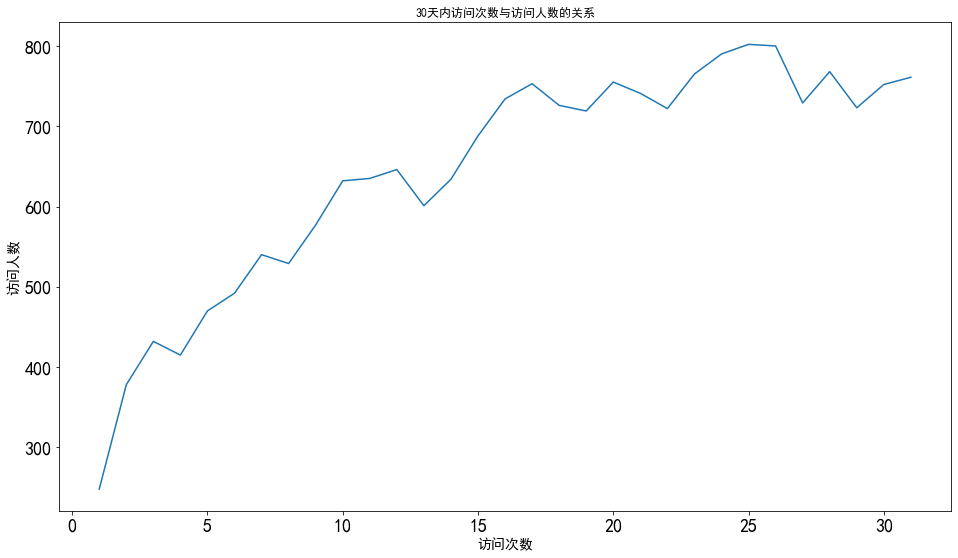

In [93]:
user_active_level = labels['counts_30_active'].value_counts().sort_index(ascending=False) #按月内活跃天数计数倒序排列
plt.figure(figsize=(16,9))
user_active_level.plot(title='30天内访问次数与访问人数的关系',fontsize=18)
plt.ylabel('访问人数',fontsize=14)
plt.xlabel('访问次数',fontsize=14)
plt.rcParams["font.sans-serif"] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [96]:
labels['user_active_level'] = '高'
labels.loc[labels['counts_30_active']<=16,'user_active_level'] = '低'
labels.head()

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,counts_7_cart,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,...,25.0,7.0,1.0,1.0,3.0,6.0,是,是,是,高
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,...,5.0,7.0,1.0,3.0,4.0,11.0,是,是,是,高
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,...,NaN,4.0,1.0,15.0,15.0,NaN,是,是,是,高
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,...,NaN,6.0,1.0,NaN,28.0,NaN,是,否,否,高
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,...,3.0,7.0,1.0,1.0,3.0,10.0,是,是,是,高


### 3.3 3.购买活跃度

In [99]:
buy_active_level.head()

99.0    1
72.0    1
65.0    1
55.0    1
42.0    1
Name: counts_30_buy, dtype: int64

In [100]:
buy_active_level.tail()

5.0     881
4.0    1245
3.0    1830
2.0    2724
1.0    4091
Name: counts_30_buy, dtype: int64

Text(0.5, 0, '购买次数')

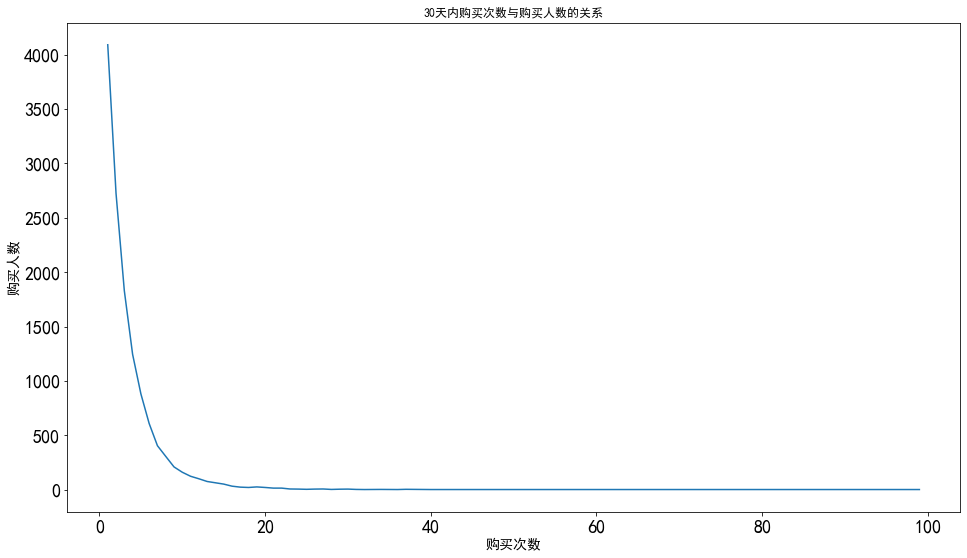

In [97]:
buy_active_level = labels['counts_30_buy'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16,9))
buy_active_level.plot(title='30天内购买次数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('购买次数',fontsize=14)

In [98]:
labels['buy_active_level'] = '高'
labels.loc[labels['counts_30_buy']<=14,'buy_active_level'] = '低'
labels.head()

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,counts_7_active,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,...,7.0,1.0,1.0,3.0,6.0,是,是,是,高,低
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,...,7.0,1.0,3.0,4.0,11.0,是,是,是,高,低
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,...,4.0,1.0,15.0,15.0,NaN,是,是,是,高,低
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,...,6.0,1.0,NaN,28.0,NaN,是,否,否,高,低
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,...,7.0,1.0,1.0,3.0,10.0,是,是,是,高,高


### 3.4 购买的品类是否单一

In [101]:
buy_single = df[df['behavior_type']==4].groupby('user_id').item_category.nunique().reset_index()
buy_single.rename(columns={'item_category':'buy_single'},inplace=True)
labels = pd.merge(labels,buy_single,how='left',on='user_id')
labels['buy_single'].fillna(-1,inplace=True)
labels['buy_single'] = labels['buy_single'].apply(lambda x: '是' if x>1 else  '否' if x==1 else '未购买' )
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,days_browse,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,...,1.0,1.0,3.0,6.0,是,是,是,高,低,是
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,...,1.0,3.0,4.0,11.0,是,是,是,高,低,是
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,...,1.0,15.0,15.0,NaN,是,是,是,高,低,否
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,...,1.0,NaN,28.0,NaN,是,否,否,高,低,否
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,...,1.0,1.0,3.0,10.0,是,是,是,高,高,是


### 3.5 用户价值分组（RFM）

R:days_buy 距上次购买的时间

F:buy_active_level 30天购买次数计算而来

Text(0.5, 0, '距今天数')

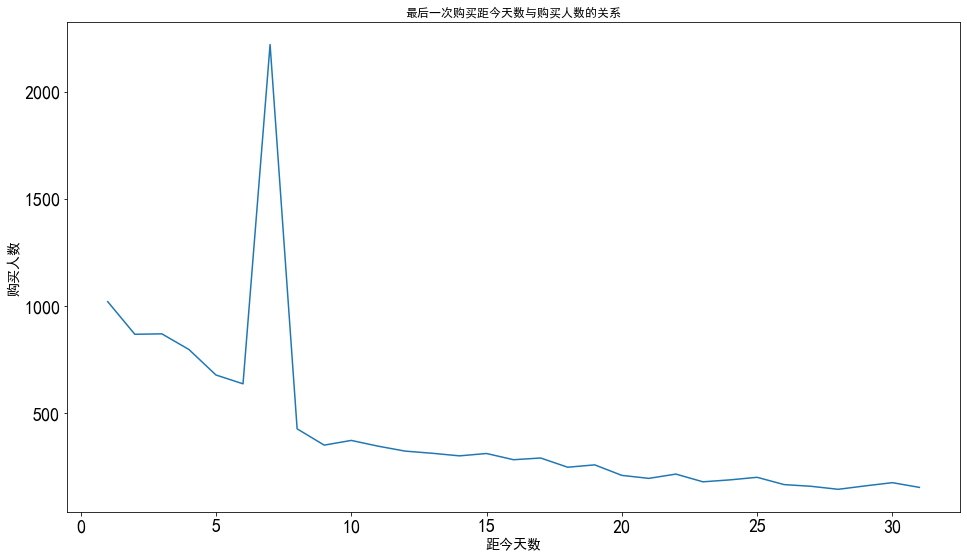

In [102]:
last_buy_days = labels['days_buy'].value_counts().sort_index()
plt.figure(figsize=(16,9))
last_buy_days.plot(title='最后一次购买距今天数与购买人数的关系',fontsize=18)
plt.ylabel('购买人数',fontsize=14)
plt.xlabel('距今天数',fontsize=14)

In [103]:
labels['buy_days_level'] = '高'
labels.loc[labels['days_buy']>8,'buy_days_level'] = '低'
labels['rfm_value'] = labels['buy_active_level'].str.cat(labels['buy_days_level']) #合并字符串，前者是F，后者是R

In [104]:
def trans_value(x):
    if x == '高高':
        return '重要价值客户'
    elif x == '低高':
        return '重要深耕客户'
    elif x == '高低':
        return '重要唤回客户'
    else: 
        return '即将流失客户'

In [105]:
labels['rfm'] = labels['rfm_value'].apply(trans_value)
labels.drop(['buy_days_level','rfm_value'],axis=1,inplace=True)
labels['rfm'].value_counts()

重要深耕客户    7277
重要价值客户    7126
即将流失客户    5542
重要唤回客户      12
Name: rfm, dtype: int64

In [106]:
labels.head(5)

,user_id,time_browse,time_buy,cate_most_browse,cate_most_collect,cate_most_cart,cate_most_buy,counts_30_buy,counts_30_cart,counts_30_active,...,days_cart,days_buy,interval_buy,browse_not_buy,cart_not_buy,buy_again,user_active_level,buy_active_level,buy_single,rfm
0,34290307,晚上,"上午,中午",5399,6936,6054,"874,7312",2.0,39.0,29,...,1.0,3.0,6.0,是,是,是,高,低,是,重要深耕客户
1,56120016,晚上,下午,3628,1337,10271,"242,3628,8415,10804",4.0,5.0,29,...,3.0,4.0,11.0,是,是,是,高,低,是,重要深耕客户
2,20961417,下午,下午,6054,NaN,"5027,5232,6054",675,2.0,3.0,26,...,15.0,15.0,NaN,是,是,是,高,低,否,即将流失客户
3,46476827,晚上,下午,6513,5399,NaN,13230,1.0,NaN,27,...,NaN,28.0,NaN,是,否,否,高,低,否,即将流失客户
4,121526027,凌晨,下午,5399,"3940,5027,6513",8291,"3940,8956,11834",16.0,41.0,31,...,1.0,3.0,10.0,是,是,是,高,高,是,重要价值客户


其实原始数据集可以再多一列，就是购买金额，用于RFM中的M分析